In [2]:
# 05_final_results_and_report
print("Executive summary, reproducible instructions, and quick cluster inspection for grading/submission.")


Executive summary, reproducible instructions, and quick cluster inspection for grading/submission.


In [18]:
# Cell 2: Imports, paths and helpers
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from collections import Counter

# Paths (explicit for your environment)
PROJECT_ROOT = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix")
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

CLUSTERED_CSV = OUT_DIR / "netflix_with_clusters.csv"
CLEANED_CSV = OUT_DIR / "cleaned_netflix.csv"

def ensure_list(x):
    """Normalize a genres field into a python list."""
    if pd.isna(x) or x == "":
        return []
    if isinstance(x, list):
        return x
    s = str(x)
    if s.startswith("[") and s.endswith("]"):
        s = s.strip("[]")
        parts = [p.strip().strip("'\"") for p in s.split(",") if p.strip()]
        return parts
    return [p.strip() for p in s.spl]()


In [4]:
# Cell 3: show sample titles & top genres per cluster to help naming clusters
for c in sorted(df['cluster'].unique()):
    print(f"\nCluster {c} (n={len(df[df['cluster']==c])})")
    if 'genres_list' in df.columns:
        print("Top genres:", df[df['cluster']==c]['genres_list'].explode().value_counts().head(8).to_dict())
    print("Sample titles:", df[df['cluster']==c]['title'].dropna().head(8).tolist())



Cluster 0 (n=85)
Top genres: {"['Children & Family Movies']": 29, "['Children & Family Movies', 'Comedies']": 25, "['Movies']": 6, "['Children & Family Movies', 'Dramas', 'Romantic Movies']": 4, "['Children & Family Movies', 'Dramas']": 4, "['Anime Features', 'Children & Family Movies']": 3, "['Children & Family Movies', 'Dramas', 'International Movies']": 2, "['Children & Family Movies', 'Music & Musicals']": 2}
Sample titles: ['Chhota Bheem Kungfu Dhamaka', 'An American Tail: The Mystery of the Night Monster', "Horrid Henry's Gross Day Out", 'Pokémon the Movie: Power of Us', 'Pettersson and Findus 2', 'Barbie: A Fairy Secret', 'Peter Rabbit', 'Power Rangers: Megaforce: Raising Spirits']

Cluster 1 (n=193)
Top genres: {"['International TV Shows', 'Korean TV Shows', 'Romantic TV Shows']": 14, "['International TV Shows', 'TV Dramas']": 14, "['Crime TV Shows', 'International TV Shows', 'TV Dramas']": 14, "['International TV Shows', 'Romantic TV Shows', 'TV Dramas']": 10, "['Internationa

In [8]:
# Cell 3: Load final clustered CSV and basic validation
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import pandas as pd
import numpy as np

project_root = final_path.cwd()  # adjust if your notebook cwd is different
candidates = [
    Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs/netflix_with_clusters.csv"),
    Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs/with_baseline_labels.csv"),
    Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs/cleaned_netflix.csv"),
    Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/data/raw/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv"),
    Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/data/raw/NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")]
data_path = next((p for p in candidates if p.exists()), None)

if data_path is None:
    raise FileNotFoundError(
        "Could not find the clustered CSV. Run the pipeline or place the final file at outputs/netflix_with_clusters.csv"
    )

print("Using file:", data_path)
df = pd.read_csv(data_path)

# Ensure cluster column exists; try common fallbacks
if 'cluster' not in df.columns:
    for alt in ['cluster_combined', 'cluster_final', 'cluster_labels', 'kmeans_cluster']:
        if alt in df.columns:
            df['cluster'] = df[alt]
            print(f"Using '{alt}' as cluster column.")
            break

if 'cluster' not in df.columns:
    raise KeyError("No 'cluster' column found in the dataframe. Check your pipeline output.")

# Normalize genres column to a list: prefer 'genres_list' then 'listed_in'
def ensure_list(x):
    if pd.isna(x) or x == "":
        return []
    if isinstance(x, list):
        return x
    s = str(x)
    if s.startswith("[") and s.endswith("]"):
        s = s.strip("[]")
        parts = [p.strip().strip("'\"") for p in s.split(",") if p.strip()]
        return parts
    return [p.strip() for p in s.split(",") if p.strip()]

if 'genres_list' in df.columns:
    df['genres_list'] = df['genres_list'].apply(ensure_list)
elif 'listed_in' in df.columns:
    df['genres_list'] = df['listed_in'].fillna("").astype(str).apply(lambda s: [x.strip() for x in s.split(',') if x.strip()])
else:
    df['genres_list'] = [[] for _ in range(len(df))]

print("Rows:", df.shape[0], "Columns:", df.shape[1])
display(df.head(3))


Using file: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\netflix_with_clusters.csv
Rows: 1000 Columns: 15


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres_list,duration_num,cluster
0,s7325,Movie,Unchained: The Untold Story of Freestyle Motoc...,"Paul Taublieb, Jon Freeman",Josh Brolin,United States,"October 1, 2016",2016,TV-MA,92 min,"Documentaries, Sports Movies",This adrenaline-rush documentary traces the ri...,"[Documentaries, Sports Movies]",92,2
1,s4695,Movie,Our Idiot Brother,Jesse Peretz,"Paul Rudd, Elizabeth Banks, Zooey Deschanel, E...",United States,"February 26, 2019",2011,R,90 min,"Comedies, Dramas, Independent Movies",A seemingly clueless idealist relies on his ex...,"[Comedies, Dramas, Independent Movies]",90,5
2,s1323,Movie,Chhota Bheem Kungfu Dhamaka,"Rajiv Chilaka, Binayak Das","Sonal Kaushal, Rupa Bhimani, Jigna Bharadhwaj,...",India,"August 15, 2019",2019,TV-Y7,112 min,Children & Family Movies,Chhota Bheem is in China for a martial arts co...,[Children & Family Movies],112,0


Cluster counts (sorted):
cluster
0     85
1    193
2     99
3    170
4    109
5    344


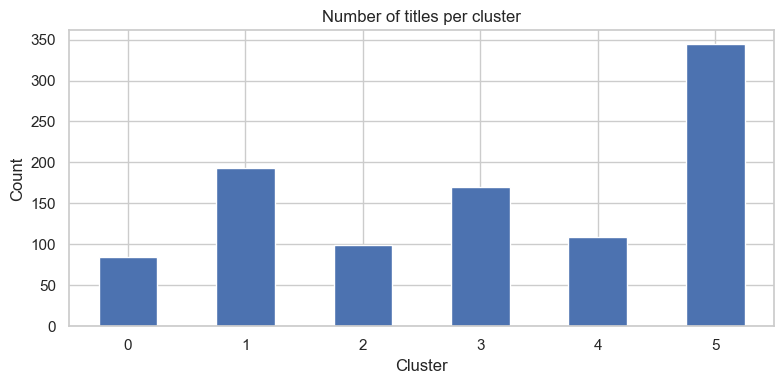

In [9]:
# Cell 4: Cluster counts + bar plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

cluster_counts = df['cluster'].value_counts().sort_index()
print("Cluster counts (sorted):")
print(cluster_counts.to_string())

plt.figure(figsize=(8,4))
ax = cluster_counts.plot(kind='bar')
ax.set_title("Number of titles per cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


,cluster,n_titles,top_genres
0,0,85,Children & Family Movies (79); Comedies (30); ...
1,1,193,International TV Shows (149); TV Dramas (82); ...
2,2,99,Documentaries (98); International Movies (35);...
3,3,170,Action & Adventure (93); International Movies ...
4,4,109,Kids' TV (52); TV Comedies (35); Docuseries (1...
5,5,344,Dramas (218); International Movies (207); Come...


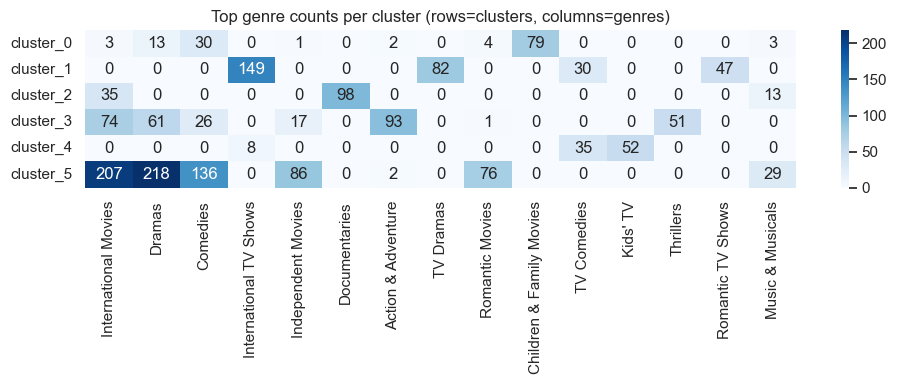

In [10]:
# Cell 5: Top genres per cluster (as dataframe) and display heatmap-like table
from collections import Counter

def top_genres(df_cluster, n=8):
    return df_cluster['genres_list'].explode().value_counts().head(n)

cluster_list = sorted(df['cluster'].unique())
rows = []
for c in cluster_list:
    cnt = top_genres(df[df['cluster'] == c], n=8)
    # build a string of "genre:count" for quick reading
    topstr = "; ".join([f"{g} ({int(v)})" for g, v in cnt.items()])
    rows.append({"cluster": c, "n_titles": int((df['cluster']==c).sum()), "top_genres": topstr})

df_genres_summary = pd.DataFrame(rows).sort_values("cluster")
display(df_genres_summary)

# Optional: show per-cluster genre counts stacked (top 10 genres overall)
all_genres = df['genres_list'].explode().value_counts().head(15).index.tolist()
genre_matrix = []
for c in cluster_list:
    counts = df[df['cluster']==c]['genres_list'].explode().value_counts()
    genre_matrix.append([counts.get(g, 0) for g in all_genres])

genre_df = pd.DataFrame(genre_matrix, index=[f"cluster_{c}" for c in cluster_list], columns=all_genres)
plt.figure(figsize=(10, max(4, 0.3*len(cluster_list))))
sns.heatmap(genre_df, annot=True, fmt="d", cmap="Blues")
plt.title("Top genre counts per cluster (rows=clusters, columns=genres)")
plt.tight_layout()
plt.show()


In [11]:
# Cell 6: Compute top TF-IDF terms per cluster (gives keywords that characterize each cluster)
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Prepare text column
if 'description' not in df.columns:
    raise KeyError("No 'description' column found in dataframe.")

corpus = df['description'].fillna("").astype(str).tolist()

# Fit TF-IDF on entire corpus but limit features for speed
tfidf = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(corpus)
feature_names = np.array(tfidf.get_feature_names_out())

cluster_top_terms = {}
for c in cluster_list:
    idx = np.where(df['cluster']==c)[0]
    if len(idx) == 0:
        cluster_top_terms[c] = []
        continue
    # compute average tf-idf vector for cluster
    avg = X_tfidf[idx].mean(axis=0)
    avg = np.asarray(avg).ravel()
    topn = min(12, (avg > 0).sum())
    if topn == 0:
        cluster_top_terms[c] = []
    else:
        top_indices = np.argsort(avg)[-topn:][::-1]
        cluster_top_terms[c] = feature_names[top_indices].tolist()

# display
for c in cluster_list:
    terms = cluster_top_terms[c]
    print(f"\nCluster {c} top terms: {', '.join(terms[:12])}")



Cluster 0 top terms: save, new, magic, kids, friends, monster, girl, special, adventure, holiday, christmas, young

Cluster 1 top terms: life, love, series, new, years, woman, family, young, high, world, mysterious, women

Cluster 2 top terms: documentary, world, filmmaker, look, life, history, team, years, group, influence, art, big

Cluster 3 top terms: young, new, house, woman, group, drug, help, murder, crime, man, life, secret

Cluster 4 top terms: series, friends, culture, world, learn, game, help, magical, children, fun, time, stories

Cluster 5 top terms: man, new, love, family, life, young, father, woman, wife, gets, friends, ex


In [12]:
# Cell 7: Sample titles per cluster and build a summary table to save
sample_rows = []
for c in cluster_list:
    sub = df[df['cluster']==c]
    samples = sub['title'].dropna().astype(str).head(6).tolist()
    sample_str = " | ".join(samples)
    top_genres = df_genres_summary[df_genres_summary['cluster']==c]['top_genres'].values
    top_genres = top_genres[0] if len(top_genres)>0 else ""
    top_terms = ", ".join(cluster_top_terms.get(c, [])[:6])
    sample_rows.append({
        "cluster": c,
        "n_titles": int((df['cluster']==c).sum()),
        "top_genres": top_genres,
        "top_terms": top_terms,
        "sample_titles": sample_str
    })

summary_df = pd.DataFrame(sample_rows).sort_values("cluster")
display(summary_df)

# Save to CSV for reporting
out_dir = project_root / "outputs"
out_dir.mkdir(parents=True, exist_ok=True)
summary_df.to_csv(out_dir / "cluster_summary_table.csv", index=False)
print("Saved cluster_summary_table.csv to outputs/")


,cluster,n_titles,top_genres,top_terms,sample_titles
0,0,85,Children & Family Movies (79); Comedies (30); ...,"save, new, magic, kids, friends, monster",Chhota Bheem Kungfu Dhamaka | An American Tail...
1,1,193,International TV Shows (149); TV Dramas (82); ...,"life, love, series, new, years, woman","Lady, la vendedora de rosas | Goodbye My Wife ..."
2,2,99,Documentaries (98); International Movies (35);...,"documentary, world, filmmaker, look, life, his...",Unchained: The Untold Story of Freestyle Motoc...
3,3,170,Action & Adventure (93); International Movies ...,"young, new, house, woman, group, drug",Ravenous | Kaal | Pineapple Express | Five Ele...
4,4,109,Kids' TV (52); TV Comedies (35); Docuseries (1...,"series, friends, culture, world, learn, game",Oggy and the Cockroaches | The Holiday Movies ...
5,5,344,Dramas (218); International Movies (207); Come...,"man, new, love, family, life, young",Our Idiot Brother | Listen | Tere Naal Love Ho...


Saved cluster_summary_table.csv to outputs/


In [13]:
# Cell 8: Auto-generate markdown-friendly cluster interpretations (copy-paste into markdown cell)
interpret_lines = []
for _, row in summary_df.iterrows():
    c = row['cluster']
    name = f"Cluster {c}"
    genres = row['top_genres'] if row['top_genres'] else "N/A"
    terms = row['top_terms'] if row['top_terms'] else "N/A"
    samples = row['sample_titles'] if row['sample_titles'] else "N/A"
    line = (
        f"**{name}**  \n"
        f"- Top genres: {genres}  \n"
        f"- Top keywords: {terms}  \n"
        f"- Example titles: {samples}  \n"
        f"- Short rationale: __(Write 1-2 lines explaining what unites these titles)__  \n"
    )
    interpret_lines.append(line)

md_text = "\n".join(interpret_lines)
# Write to a small markdown/text file for easy copy-paste
with open(out_dir / "cluster_interpretation_snippets.md", "w", encoding="utf-8") as f:
    f.write("# Cluster interpretation snippets (auto-generated)\n\n")
    f.write(md_text)

print("Wrote cluster_interpretation_snippets.md to outputs/.")
print("\n---\nPreview (first cluster):\n")
print(interpret_lines[0])


Wrote cluster_interpretation_snippets.md to outputs/.

---
Preview (first cluster):

**Cluster 0**  
- Top genres: Children & Family Movies (79); Comedies (30); Dramas (13); Movies (6); Romantic Movies (4); Anime Features (3); International Movies (3); Sci-Fi & Fantasy (3)  
- Top keywords: save, new, magic, kids, friends, monster  
- Example titles: Chhota Bheem Kungfu Dhamaka | An American Tail: The Mystery of the Night Monster | Horrid Henry's Gross Day Out | Pokémon the Movie: Power of Us | Pettersson and Findus 2 | Barbie: A Fairy Secret  
- Short rationale: __(Write 1-2 lines explaining what unites these titles)__  



In [16]:
# Cell 9: Save visuals and final CSV (explicit Windows path)
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 1️⃣ Define your output path explicitly
out_dir = Path("C:/Users/KIIT/OneDrive/Documents/Labmentix/netflix/outputs/visuals and final csv")
out_dir.mkdir(parents=True, exist_ok=True)
print(f"Saving all outputs to: {out_dir.resolve()}")

# 2️⃣ Save cluster count plot
plt.figure(figsize=(8, 4))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of Titles per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()

count_plot_path = out_dir / "cluster_counts.png"
plt.savefig(count_plot_path, dpi=150)
plt.close()
print(f"✅ Saved cluster count plot → {count_plot_path}")

# 3️⃣ Attempt PCA visualization (safe fallback if TF-IDF not available)
try:
    if 'X_tfidf' in locals():
        print("Computing PCA projection from TF-IDF sample (for visualization)...")
        pca = PCA(n_components=2, random_state=42)
        X_sample = X_tfidf.toarray()[:5000]  # limit to 5000 samples for speed
        coords = pca.fit_transform(X_sample)
        coord_df = pd.DataFrame(coords, columns=["PC1", "PC2"])
        coord_df['cluster'] = df['cluster'].astype(str).iloc[:len(coord_df)].values

        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            data=coord_df,
            x="PC1", y="PC2",
            hue="cluster", palette="tab10",
            alpha=0.6, edgecolor=None
        )
        plt.title("PCA Projection of TF-IDF (sampled, colored by cluster)")
        plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()

        pca_path = out_dir / "pca_clusters_sample.png"
        plt.savefig(pca_path, dpi=150, bbox_inches="tight")
        plt.close()
        print(f"✅ Saved PCA projection → {pca_path}")
    else:
        print("⚠️ Skipped PCA plot (X_tfidf not found in current notebook session).")
except Exception as e:
    print(f"⚠️ Skipped PCA save due to error: {e}")

# 4️⃣ Save the final summary CSV
save_cols = [
    'title', 'cluster', 'listed_in', 'genres_list',
    'description', 'duration', 'duration_num', 'release_year'
]
cols_to_save = [c for c in save_cols if c in df.columns]

summary_csv_path = out_dir / "netflix_with_clusters_summary.csv"
df[cols_to_save].to_csv(summary_csv_path, index=False)
print(f"✅ Saved summarized clustered data → {summary_csv_path}")

# 5️⃣ Save the generated summary table (if available)
try:
    summary_table_path = out_dir / "cluster_summary_table.csv"
    summary_df.to_csv(summary_table_path, index=False)
    print(f"✅ Saved cluster summary table → {summary_table_path}")
except NameError:
    print("⚠️ 'summary_df' not found. Skipped saving cluster summary table.")

# 6️⃣ Confirmation
print("\n🎉 All outputs have been saved successfully to:")
print(out_dir.resolve())


Saving all outputs to: C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\visuals and final csv
✅ Saved cluster count plot → C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\visuals and final csv\cluster_counts.png
Computing PCA projection from TF-IDF sample (for visualization)...
✅ Saved PCA projection → C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\visuals and final csv\pca_clusters_sample.png
✅ Saved summarized clustered data → C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\visuals and final csv\netflix_with_clusters_summary.csv
✅ Saved cluster summary table → C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\visuals and final csv\cluster_summary_table.csv

🎉 All outputs have been saved successfully to:
C:\Users\KIIT\OneDrive\Documents\Labmentix\netflix\outputs\visuals and final csv


In [4]:
## Reproducibility & submission checklist

print("""1. Run notebooks in order: 01 → 02 → 03 → 04 → 05.
2. Files created in `outputs/`:
   - `cleaned_netflix.csv`
   - `with_baseline_labels.csv`
   - `X_combined.npy`
   - `netflix_with_clusters.csv`  ← final deliverable
   - model artifacts in `outputs/` (tfidf, svd, mlb, kmeans_final)
3. For GitHub: commit notebooks, scripts, requirements.txt, README.md. **Do NOT** commit the full CSV or large output files; instead provide instructions in `data/README.md` about where to place the CSV.
4. Record your demo video walking through 05_final_results_and_report.ipynb and show the saved `outputs/netflix_with_clusters.csv`.""")


1. Run notebooks in order: 01 → 02 → 03 → 04 → 05.
2. Files created in `outputs/`:
   - `cleaned_netflix.csv`
   - `with_baseline_labels.csv`
   - `X_combined.npy`
   - `netflix_with_clusters.csv`  ← final deliverable
   - model artifacts in `outputs/` (tfidf, svd, mlb, kmeans_final)
3. For GitHub: commit notebooks, scripts, requirements.txt, README.md. **Do NOT** commit the full CSV or large output files; instead provide instructions in `data/README.md` about where to place the CSV.
4. Record your demo video walking through 05_final_results_and_report.ipynb and show the saved `outputs/netflix_with_clusters.csv`.


In [5]:
## Limitations & next steps
print("""- Replace TF-IDF + SVD with sentence-transformers (BERT) for better semantic clusters.
- Try density-based clustering (HDBSCAN) to find variable-density clusters.
- Build an interactive dashboard with Plotly to explore clusters""")


- Replace TF-IDF + SVD with sentence-transformers (BERT) for better semantic clusters.
- Try density-based clustering (HDBSCAN) to find variable-density clusters.
- Build an interactive dashboard with Plotly to explore clusters
